<a href="https://colab.research.google.com/github/ANGJIN/UrbanSound8KRNN/blob/master/UrbanSound8K_Classification_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

My UrbanSound8K data is in google drive.  
So, mount google drive first

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Change present working directory to urban sound classification directory  
which is in mounted Google drive.

In [2]:
%cd 'drive/My Drive/urban sound classification'

/content/drive/My Drive/urban sound classification


Import modules

In [4]:
import glob
import os
import librosa
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.display import SVG
import keras
from keras.utils.vis_utils import model_to_dot
from keras.models import Sequential, load_model
from keras.layers import LSTM, Activation
from keras.layers import Dropout, Dense, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


Below, there are some functions to load and pre-process data.

In [0]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield int(start), int(start + window_size)
        start += (window_size / 2)

generator function for 'windowing' data.  
returns indices of start and end of each window, size of parameter 'window_size'  
As you can see in code. windows are overlapped of half-window size

In [0]:
import pickle
def extract_features(parent_dir,sub_dirs,file_ext="*.wav",bands = 20, frames = 41):
    window_size = 512 * (frames - 1)
    for l, sub_dir in enumerate(sub_dirs):
        mfccs = []
        log_specgrams = []
        labels = []
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            sound_clip,s = librosa.load(fn)
            #UrbanSound8K/audio/fold*/*.wav
            label = fn.split('/')[-1].split('-')[1]
            for (start,end) in windows(sound_clip,window_size):
              if len(sound_clip[start:end]) == window_size:
                signal = sound_clip[start:end]
                #melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
                #logspec = librosa.amplitude_to_db(melspec)
                #logspec = logspec.T.flatten()[:, np.newaxis].T
                #log_specgrams.append(logspec)
                mfcc = librosa.feature.mfcc(y=signal, sr=s, n_mfcc = bands).T.flatten()[:, np.newaxis].T
                mfccs.append(mfcc)
                labels.append(label)         
        #feature = np.hstack(mfcc, logspec)
        feature = np.asarray(mfccs).reshape(len(mfccs),frames,bands)
        filename = 'mfcc_features_{}.pk'.format(sub_dir)
        #filename = 'melspec_mfcc_features_{}.pk'.format(sub_dir)
        f=open(filename,'wb')
        pickle.dump(feature,f)
        f.close()
        filename = 'mfcc_labels_{}.pk'.format(sub_dir)
        f=open(filename,'wb')
        pickle.dump(labels,f)
        f.close()
        print('finish loading {}, shape : {}'.format(sub_dir,feature.shape))
    #features = np.hstack((mfccs, log_specgrams))
    #features = np.asarray(features).reshape(len(features),frames,bands)

In [0]:
sub_dirs = ['fold{}'.format(i) for i in range(9,11)]
extract_features(parent_dir,sub_dirs)

finish loading fold9, shape : (5118, 41, 20)
finish loading fold10, shape : (5218, 41, 20)


Read and pre-process all data in each 'fold_'.  
Open and process each wav data with librosa.mfcc module and return list of data and labels.

In [0]:
def one_hot_encode(labels):
    n_labels = len(labels)
    labels = np.asarray(labels, dtype=np.int)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

One hot encoding function. labels returned from extract_features function is like  
[1,3,2,...].  
We have to convert this labels to form of one hot encode data like  
[[0,1,0,0,0,0,...]   
 [0,0,0,1,0,0,...]  
 [0,0,1,0,0,0,...]...].

We will use data in fold1-6 to train.  
Use data in fold7-9 to validate.  
Use data in fold10 to test model.

In [0]:
import pickle
tr_features = []
tr_labels = []
ts_features = []
ts_labels = []

for sub_dir in ['fold{}'.format(i) for i in range(1,10)] :
  feature_file = 'mfcc_features_{}.pk'.format(sub_dir)
  label_file = 'mfcc_labels_{}.pk'.format(sub_dir)
  f1=open(feature_file,'rb')
  f2=open(label_file,'rb')
  tmp_features = pickle.load(f1)
  tmp_labels = pickle.load(f2)
  f1.close()
  f2.close()
  tr_features.extend(tmp_features)
  tr_labels.extend(tmp_labels)
tr_features=np.asarray(tr_features)
tr_labels=one_hot_encode(tr_labels)

for sub_dir in ['fold{}'.format(i) for i in range(7,10)] :
  feature_file = 'mfcc_features_{}.pk'.format(sub_dir)
  label_file = 'mfcc_labels_{}.pk'.format(sub_dir)
  f1=open(feature_file,'rb')
  f2=open(label_file,'rb')
  tmp_features = pickle.load(f1)
  tmp_labels = pickle.load(f2)
  f1.close()
  f2.close()
  ts_features.extend(tmp_features)
  ts_labels.extend(tmp_labels)
ts_features=np.asarray(ts_features)
ts_labels=one_hot_encode(ts_labels)

sub_dir = 'fold10' #10 fold for test data
feature_file = 'mfcc_features_{}.pk'.format(sub_dir)
label_file = 'mfcc_labels_{}.pk'.format(sub_dir)
f1=open(feature_file,'rb')
f2=open(label_file,'rb')
test_features = pickle.load(f1)
test_labels = pickle.load(f2)
f1.close()
f2.close()
test_features = np.asarray(test_features)
test_labels = one_hot_encode(test_labels)

Ok, now let's check data shape.

In [0]:
print(tr_features.shape, tr_labels.shape)
print(ts_features.shape, ts_labels.shape)
print(test_features.shape, test_labels.shape)

(48840, 41, 20) (48840, 10)
(15337, 41, 20) (15337, 10)
(5218, 41, 20) (5218, 10)


I intend to split data size of train : validate : test to 6:3:1  

In [0]:
# Training Parameters
epochs = 50
batch_size = 50

# Network Parameters
n_input = 40
n_steps = 41
n_hidden = 20
n_classes = 10
use_dropout = False

I build RNN model with 2 layers of LSTM and Dense layer is following after those layers.

In [0]:
model = Sequential()
model.add(LSTM(n_hidden, input_shape=(n_steps,n_hidden), return_sequences=True))
model.add(LSTM(n_hidden, return_sequences=False))
model.add(Dense(n_classes))
model.add(Activation('softmax'))

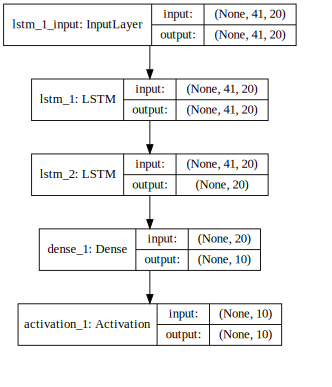

In [0]:
SVG(model_to_dot(model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

Use adam optimizer, categorical crossentropy for loss function and categorical accuracy for metric.

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 41, 20)            3280      
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 6,770
Trainable params: 6,770
Non-trainable params: 0
_________________________________________________________________


In [0]:
checkpointer = ModelCheckpoint(filepath='2LSTM_hidden20-{epoch:02d}.hdf5', verbose=1)

save model for each epoch

In [0]:
import time
start = time.time()
model.fit(tr_features,tr_labels,epochs=epochs,batch_size=batch_size,validation_data=(ts_features,ts_labels), callbacks=[checkpointer])
end = time.time()
elapsed_time = end-start
print("learning time : {}".format(elapsed_time))

Train on 48840 samples, validate on 15337 samples
Epoch 1/50
48840/48840 [==============================] - 176s 4ms/step - loss: 1.0335 - categorical_accuracy: 0.6670 - val_loss: 0.9204 - val_categorical_accuracy: 0.7091

Epoch 00001: saving model to 2LSTM_hidden20-01.hdf5
Epoch 2/50
48840/48840 [==============================] - 174s 4ms/step - loss: 0.9361 - categorical_accuracy: 0.7024 - val_loss: 0.8342 - val_categorical_accuracy: 0.7402

Epoch 00002: saving model to 2LSTM_hidden20-02.hdf5
Epoch 3/50
48840/48840 [==============================] - 175s 4ms/step - loss: 0.8766 - categorical_accuracy: 0.7184 - val_loss: 0.7760 - val_categorical_accuracy: 0.7550

Epoch 00003: saving model to 2LSTM_hidden20-03.hdf5
Epoch 4/50
45550/48840 [==========================>...] - ETA: 10s - loss: 0.8326 - categorical_accuracy: 0.7309

Training time is average 180 seconds per epoch.

In [0]:
model.save('2LSTM_hidden20.hdf5')

save trained model

In [0]:
model = load_model('2LSTM_hidden20-01.hdf5')

load trained model

In [16]:
tr_accuracy = []
test_accuracy = []
for epoch in [1,5,10,20,30,40]:
  model = load_model('2LSTM_hidden20-{:02d}.hdf5'.format(epoch))
  # Evaluating the model on the training and testing set
  score = model.evaluate(tr_features, tr_labels, verbose=1)
  print("Training Accuracy: ", score[1])
  tr_accuracy.append(score[1])
  score = model.evaluate(test_features, test_labels, verbose=1)
  print("Testing Accuracy: ", score[1])
  test_accuracy.append(score[1])

48840/48840 [==============================] - 105s 2ms/step
Training Accuracy:  0.8023546273546274
5218/5218 [==============================] - 11s 2ms/step
Testing Accuracy:  0.5137983901878114
48840/48840 [==============================] - 106s 2ms/step
Training Accuracy:  0.8129197379197379
5218/5218 [==============================] - 12s 2ms/step
Testing Accuracy:  0.4938673821387505
48840/48840 [==============================] - 108s 2ms/step
Training Accuracy:  0.8166052416052416
5218/5218 [==============================] - 11s 2ms/step
Testing Accuracy:  0.5218474511307014
48840/48840 [==============================] - 109s 2ms/step
Training Accuracy:  0.8392301392301392
5218/5218 [==============================] - 11s 2ms/step
Testing Accuracy:  0.5015331544653123
48840/48840 [==============================] - 108s 2ms/step
Training Accuracy:  0.8469082719082719
5218/5218 [==============================] - 11s 2ms/step
Testing Accuracy:  0.4639708700651591
48840/48840 [=======

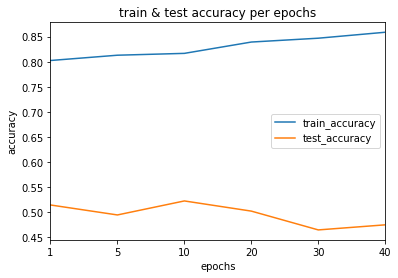

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

result = pd.DataFrame({'train_accuracy': tr_accuracy, 'test_accuracy' : test_accuracy})
result.plot()
plt.xticks(np.arange(6),[1,5,10,20,30,40])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('train & test accuracy per epochs')
plt.legend(loc='best')
plt.show()

Training accuracy is above 0.8
Testing accuracy is near 0.5  
Maybe somewhy, model is overfitted to training data.  
I think applying regularization and normalization methods can solve this problem.